## BIOF509 Machine Learning Final Project
## Title: ML to predict Sjogren syndrome subgroups based on transcriptional profile 


Author: \
Agustin Alejandro Martinez Chibly 

Data Source: \
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE154926 \
A table with sample information was manually curated and available  in github: \
https://github.com/chiblyaa/GSE154926/blob/main/SampleInfo.csv

Project Description: \
This dataset contains Bulk RNA sequencing in minor salivary glands of Brazilian patients with primary Sjögren’s syndrome (SS) and healthy volunteers.
Study by: Contributor(s) Chiorini JA, Mo Y, Pranzatelli TJ, Michael DG, Ji Y, Rocha EM Available in GEO: GSE154926. \
We will use an unsupervised machine learning approach to identify subtypes of sjogren's syndrome (ss) based on their transcriptional profile. We will then generate a supervised model using Random Forest Classifiers (RFC) to predict subgroups of SS with the most significant featured identified in our unsupervised clustering approach.



## Load the data and packages
### Required packages

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive/')
os.chdir("/content/drive/My Drive/BIOF509/FinalProject/")

Mounted at /content/drive/


In [63]:

import pandas as pd
import numpy as np
import seaborn as sns

import umap ###install with "pip install umap-learn"

from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.metrics import explained_variance_score, mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.svm import SVC
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib as matplot

### Load csv data files

In [72]:
# We load the data and merge into a single table with all features and sample information
df1 = pd.read_csv('./SampleInfo.csv', index_col= "Sample")
df2 = pd.read_csv('./GSE154926_Normalized_CPM.csv', index_col="Gene", header=0)

df2 = df2.transpose()
data = pd.concat([df1.reindex(df2.index), df2], axis=1)

In [73]:
# The Dx column is the categorical value we'll use for supervised analysis
# All ENSG columns are normalized gene expression values
data.head()


,Dx,Age,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,ENSG00000001497,ENSG00000001561,ENSG00000001617,ENSG00000001626,ENSG00000001629,ENSG00000001630,ENSG00000001631,ENSG00000002016,ENSG00000002079,ENSG00000002330,ENSG00000002549,ENSG00000002586,ENSG00000002587,ENSG00000002726,ENSG00000002745,ENSG00000002746,ENSG00000002822,ENSG00000002834,ENSG00000002919,ENSG00000002933,ENSG00000003056,ENSG00000003096,ENSG00000003137,ENSG00000003147,ENSG00000003249,ENSG00000003393,...,ENSG00000283189,ENSG00000283194,ENSG00000283208,ENSG00000283217,ENSG00000283224,ENSG00000283229,ENSG00000283236,ENSG00000283241,ENSG00000283245,ENSG00000283251,ENSG00000283253,ENSG00000283263,ENSG00000283266,ENSG00000283294,ENSG00000283295,ENSG00000283299,ENSG00000283310,ENSG00000283332,ENSG00000283341,ENSG00000283368,ENSG00000283374,ENSG00000283382,ENSG00000283390,ENSG00000283396,ENSG00000283430,ENSG00000283467,ENSG00000283472,ENSG00000283473,ENSG00000283485,ENSG00000283495,ENSG00000283496,ENSG00000283549,ENSG00000283580,ENSG00000283590,ENSG00000283597,ENSG00000283602,ENSG00000283617,ENSG00000283632,ENSG00000283652,ENSG00000283663
BRA2,Control,21,327.528665,0.186387,12.254949,19.850222,2.842403,0.792145,45.012476,40.818767,7.036112,7.129305,5.731402,141.001813,32.943913,32.617736,0.093194,9.925111,15.982691,106.054238,15.936094,18.731900,0.0,5.125644,56.428683,49.578959,4.147112,0.186387,0.000000,0.419371,2.003661,19.524045,16.308868,4.286902,82.988840,1.630887,0.232984,70.034939,2.050258,11.602595,...,0.000000,0.652355,0.512564,0.0,1.863871,70.361116,0.139790,2.935596,0.000000,0.0,0.000000,0.000000,0.419371,0.046597,0.0,0.000000,0.0,0.0,0.139790,0.0,0.093194,0.0,14.538191,0.139790,9.319353,0.186387,0.0,0.232984,5.545015,0.000000,0.0,0.465968,0.093194,0.000000,0.0,0.046597,0.372774,0.0,0.698951,0.000000
BRA3,Control,59,183.417942,1.379082,25.581976,13.411575,3.378752,3.240843,133.770981,46.923274,5.068127,5.516329,9.032989,93.329393,35.545846,19.824308,0.379248,8.688218,11.825630,143.010832,14.756180,27.754031,0.0,17.790161,91.295246,232.340886,14.894089,0.689541,0.310294,0.930881,3.102935,21.410252,19.203721,40.441588,117.635718,3.826953,2.137578,62.506904,2.344440,12.204878,...,0.000000,1.344605,0.999835,0.0,0.000000,166.213891,0.068954,1.241174,2.482348,0.0,0.517156,0.000000,0.551633,0.000000,0.0,0.827449,0.0,0.0,0.517156,0.0,0.000000,0.0,24.202894,0.551633,78.193965,0.827449,0.0,0.999835,0.000000,0.172385,0.0,0.724018,0.310294,1.896238,0.0,0.172385,3.723522,0.0,0.344771,0.000000
BRA4,Control,71,270.363753,0.081558,11.744308,19.084500,4.567231,0.897135,76.174885,36.456289,6.606173,6.279942,6.687731,121.439405,33.193981,40.452616,0.163115,2.772962,15.332846,167.030156,24.630423,22.673039,0.0,8.074212,64.675251,69.568712,6.606173,0.570904,0.000000,0.489346,1.712712,26.506250,13.293904,4.077885,81.231462,2.772962,0.815577,77.153578,2.283615,11.499635,...,0.000000,0.000000,0.978692,0.0,0.000000,79.192520,0.000000,1.468038,1.631154,0.0,0.000000,0.000000,0.244673,0.163115,0.0,3.180750,0.0,0.0,0.000000,0.0,0.000000,0.0,9.542250,0.326231,0.000000,0.000000,0.0,0.570904,7.095519,0.000000,0.0,0.081558,0.000000,0.815577,0.0,0.000000,0.000000,0.0,0.815577,0.000000
BRA31,Control,24,168.021124,0.196115,19.905625,12.600359,2.843661,1.912117,37.457875,29.564265,5.883436,4.314520,6.422751,86.731651,24.759459,17.356136,0.049029,4.020348,11.962986,64.962938,13.924132,8.580011,0.0,12.453273,75.602151,69.130372,1.912117,0.098057,0.000000,0.686401,2.745603,18.826995,13.335788,7.893610,87.565138,2.255317,0.000000,54.764982,1.961145,9.217383,...,0.490286,0.000000,0.441258,0.0,0.000000,62.609564,0.000000,4.265491,0.098057,0.0,0.000000,0.294172,0.000000,0.049029,0.0,0.000000,0.0,0.0,0.196115,0.0,0.000000,0.0,14.316361,0.196115,26.720605,0.931544,0.0,0.294172,2.059203,0.000000,0.0,0.441258,0.147086,0.000000,0.0,0.196115,0.392229,0.0,0.000000,

### Clean and pre-process data

In [79]:
# fill in missing data
data.fillna(0, inplace=True)
# save categorical labels as target for SL
data["Dx"] = pd.Categorical(data["Dx"])
data["Dx"] = data["Dx"].cat.codes

target = data["Dx"]
clean_data = data.drop(columns=["Dx"])
clean_data = clean_data.loc[:, (clean_data==0).mean() < .7] # drop columns with 70% zero values

In [87]:
clean_data.head()

,Age,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,ENSG00000001497,ENSG00000001561,ENSG00000001617,ENSG00000001626,ENSG00000001629,ENSG00000001630,ENSG00000001631,ENSG00000002016,ENSG00000002330,ENSG00000002549,ENSG00000002586,ENSG00000002587,ENSG00000002726,ENSG00000002745,ENSG00000002746,ENSG00000002822,ENSG00000002834,ENSG00000002919,ENSG00000002933,ENSG00000003056,ENSG00000003096,ENSG00000003137,ENSG00000003147,ENSG00000003249,ENSG00000003393,ENSG00000003400,ENSG00000003402,...,ENSG00000281896,ENSG00000282034,ENSG00000282057,ENSG00000282246,ENSG00000282608,ENSG00000282619,ENSG00000282728,ENSG00000282772,ENSG00000282826,ENSG00000282915,ENSG00000282951,ENSG00000282960,ENSG00000283050,ENSG00000283143,ENSG00000283147,ENSG00000283149,ENSG00000283154,ENSG00000283155,ENSG00000283182,ENSG00000283208,ENSG00000283224,ENSG00000283229,ENSG00000283236,ENSG00000283241,ENSG00000283245,ENSG00000283266,ENSG00000283294,ENSG00000283299,ENSG00000283341,ENSG00000283390,ENSG00000283396,ENSG00000283430,ENSG00000283467,ENSG00000283473,ENSG00000283485,ENSG00000283549,ENSG00000283580,ENSG00000283590,ENSG00000283602,ENSG00000283652
BRA2,21,327.528665,0.186387,12.254949,19.850222,2.842403,0.792145,45.012476,40.818767,7.036112,7.129305,5.731402,141.001813,32.943913,32.617736,0.093194,9.925111,15.982691,106.054238,15.936094,18.731900,5.125644,56.428683,49.578959,4.147112,0.186387,0.000000,0.419371,2.003661,19.524045,16.308868,4.286902,82.988840,1.630887,0.232984,70.034939,2.050258,11.602595,14.305207,57.314022,...,0.419371,4.053919,0.139790,0.000000,0.512564,0.605758,0.512564,6.010983,2.096854,0.186387,2.190048,3.261774,0.326177,0.139790,7.595273,2.982193,0.279581,0.0,1.258113,0.512564,1.863871,70.361116,0.139790,2.935596,0.000000,0.419371,0.046597,0.000000,0.139790,14.538191,0.139790,9.319353,0.186387,0.232984,5.545015,0.465968,0.093194,0.000000,0.046597,0.698951
BRA3,59,183.417942,1.379082,25.581976,13.411575,3.378752,3.240843,133.770981,46.923274,5.068127,5.516329,9.032989,93.329393,35.545846,19.824308,0.379248,8.688218,11.825630,143.010832,14.756180,27.754031,17.790161,91.295246,232.340886,14.894089,0.689541,0.310294,0.930881,3.102935,21.410252,19.203721,40.441588,117.635718,3.826953,2.137578,62.506904,2.344440,12.204878,20.444895,74.677305,...,0.103431,8.033154,0.344771,0.000000,0.965358,0.482679,0.448202,4.895742,3.447706,0.172385,1.413559,1.861761,0.034477,0.172385,3.102935,1.896238,0.000000,0.0,1.654899,0.999835,0.000000,166.213891,0.068954,1.241174,2.482348,0.551633,0.000000,0.827449,0.517156,24.202894,0.551633,78.193965,0.827449,0.999835,0.000000,0.724018,0.310294,1.896238,0.172385,0.344771
BRA4,71,270.363753,0.081558,11.744308,19.084500,4.567231,0.897135,76.174885,36.456289,6.606173,6.279942,6.687731,121.439405,33.193981,40.452616,0.163115,2.772962,15.332846,167.030156,24.630423,22.673039,8.074212,64.675251,69.568712,6.606173,0.570904,0.000000,0.489346,1.712712,26.506250,13.293904,4.077885,81.231462,2.772962,0.815577,77.153578,2.283615,11.499635,9.379135,62.962539,...,0.326231,5.056577,0.244673,0.978692,1.060250,0.407788,0.244673,16.964000,3.017635,0.407788,0.000000,1.549596,0.000000,0.407788,8.155769,2.365173,0.000000,0.0,2.772962,0.978692,0.000000,79.192520,0.000000,1.468038,1.631154,0.244673,0.163115,3.180750,0.000000,9.542250,0.326231,0.000000,0.000000,0.570904,7.095519,0.081558,0.000000,0.815577,0.000000,0.815577
BRA31,24,168.021124,0.196115,19.905625,12.600359,2.843661,1.912117,37.457875,29.564265,5.883436,4.314520,6.422751,86.731651,24.759459,17.356136,0.049029,4.020348,11.962986,64.962938,13.924132,8.580011,12.453273,75.602151,69.130372,1.912117,0.098057,0.000000,0.686401,2.745603,18.826995,13.335788,7.893610,87.565138,2.255317,0.000000,54.764982,1.961145,9.217383,11.374643,46.724287,...,0.098057,4.314520,0.196115,0.000000,2.500460,0.000000,0.294172,8.481953,3.824233,0.049029,0.000000,2.206

## Data scaling


In [88]:
#from sklearn.preprocessing import StandardScaler
#data_for_scaling = clean_data.values
#scaler = StandardScaler()
#scaled_data = scaler.fit_transform(data_for_scaling)
#print(scaled_data[0:5])

norm_data = (clean_data-clean_data.min())/(clean_data.max()-clean_data.min())
norm_data.fillna(0, inplace=True)
norm_data.head()

,Age,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,ENSG00000001497,ENSG00000001561,ENSG00000001617,ENSG00000001626,ENSG00000001629,ENSG00000001630,ENSG00000001631,ENSG00000002016,ENSG00000002330,ENSG00000002549,ENSG00000002586,ENSG00000002587,ENSG00000002726,ENSG00000002745,ENSG00000002746,ENSG00000002822,ENSG00000002834,ENSG00000002919,ENSG00000002933,ENSG00000003056,ENSG00000003096,ENSG00000003137,ENSG00000003147,ENSG00000003249,ENSG00000003393,ENSG00000003400,ENSG00000003402,...,ENSG00000281896,ENSG00000282034,ENSG00000282057,ENSG00000282246,ENSG00000282608,ENSG00000282619,ENSG00000282728,ENSG00000282772,ENSG00000282826,ENSG00000282915,ENSG00000282951,ENSG00000282960,ENSG00000283050,ENSG00000283143,ENSG00000283147,ENSG00000283149,ENSG00000283154,ENSG00000283155,ENSG00000283182,ENSG00000283208,ENSG00000283224,ENSG00000283229,ENSG00000283236,ENSG00000283241,ENSG00000283245,ENSG00000283266,ENSG00000283294,ENSG00000283299,ENSG00000283341,ENSG00000283390,ENSG00000283396,ENSG00000283430,ENSG00000283467,ENSG00000283473,ENSG00000283485,ENSG00000283549,ENSG00000283580,ENSG00000283590,ENSG00000283602,ENSG00000283652
BRA2,0.106061,0.913361,0.035967,0.157079,0.573786,0.249345,0.022678,0.081366,0.278111,0.301093,0.329977,0.272658,0.634096,0.385635,0.471487,0.047940,0.333374,0.327235,0.214073,0.340135,0.239276,0.000000,0.159271,0.000000,0.099904,0.079964,0.000000,0.066133,0.131303,0.216696,0.395143,0.033890,0.197446,0.124922,0.034903,0.548485,0.285067,0.385070,0.125113,0.211061,...,0.425188,0.086918,0.105041,0.000000,0.023262,0.355428,0.476064,0.257679,0.332848,0.147636,0.648286,0.658321,0.278113,0.117885,0.347422,0.467093,0.187479,0.0,0.257250,0.171408,0.220056,0.036907,0.168209,0.143820,0.000000,0.046022,0.078739,0.000000,0.076475,0.130732,0.080326,0.044638,0.034652,0.077967,0.195547,0.201852,0.142484,0.000000,0.050210,0.121948
BRA3,0.681818,0.492548,0.266120,0.685317,0.363535,0.296396,0.092779,0.301343,0.331482,0.201866,0.251667,0.498210,0.391038,0.416154,0.285037,0.195090,0.290953,0.234356,0.382492,0.313315,0.359189,0.610239,0.277657,0.239172,0.580295,0.295826,0.385458,0.175292,0.239151,0.240839,0.477484,0.550721,0.289787,0.293135,0.320227,0.484779,0.333174,0.405418,0.233540,0.327348,...,0.104866,0.286771,0.259068,0.000000,0.043811,0.283212,0.416285,0.204005,0.547278,0.136546,0.418434,0.365390,0.029397,0.145373,0.141934,0.297003,0.000000,0.0,0.338382,0.334357,0.000000,0.281373,0.082972,0.060807,0.510780,0.060537,0.000000,0.152341,0.282922,0.261916,0.316977,0.374536,0.153834,0.334590,0.000000,0.313637,0.474410,0.827102,0.185754,0.060153
BRA4,0.863636,0.746436,0.015738,0.136839,0.548782,0.400653,0.025683,0.158598,0.239971,0.279415,0.288741,0.337991,0.534357,0.388568,0.585671,0.083909,0.088081,0.312716,0.491953,0.537757,0.291658,0.142076,0.187272,0.026160,0.209825,0.244929,0.000000,0.081066,0.102759,0.306068,0.309385,0.030903,0.192762,0.212402,0.122180,0.608726,0.323227,0.381591,0.038119,0.248891,...,0.330756,0.137275,0.183853,0.789510,0.048117,0.239270,0.227250,0.784818,0.479010,0.323008,0.000000,0.300074,0.000000,0.343888,0.373060,0.370451,0.000000,0.0,0.566995,0.327287,0.000000,0.059431,0.000000,0.071922,0.335634,0.026851,0.275630,0.585607,0.000000,0.062919,0.187458,0.000000,0.000000,0.191050,0.250226,0.035330,0.000000,0.355739,0.000000,0.142295
BRA31,0.151515,0.447588,0.037844,0.460326,0.337045,0.249456,0.054740,0.062643,0.179715,0.242974,0.193319,0.319888,0.357399,0.289635,0.249067,0.025221,0.130862,0.237424,0.026812,0.294403,0.104348,0.353081,0.224373,0.025586,0.000000,0.042068,0.000000,0.123119,0.204094,0.207773,0.310576,0.085448,0.209643,0.172752,0.000000,0.419264,0.270495,0.304487,0.073360,0.140139,...,0.099418,0.100006,0.147365,0.000000,0.113478,0.000000,0.273223,0.376600,0.607046,0.038835,0.000000,0.437477,0.041804,0.248075,0.405921,0.583621,0.394526,0.0,0.000000,0.147562,0.000000,0

## Dimensionality Reduction (UMAP)
We use UMAP to reduce our data prior to unsupervised learning to determine SS subgroups (clusters). Data reduction will also provide the most important features for classification into subgroups which we will test in our supervised algortithm

In [89]:
data_reducer = umap.UMAP()
''' 
Use fit_transform to reduce data
'''
umap_data = data_reducer.fit_transform(norm_data)

''' 
Scale the low-dimensional data to prepare it for machine learning algorithms 
'''

scaled_umap_data = scaler.fit_transform(umap_data)
print(scaled_umap_data)

[[ 0.48877755 -1.06159   ]
 [-0.40002075  0.83308107]
 [ 0.42258254 -1.2092903 ]
 [-0.5198929  -1.1867989 ]
 [ 1.0452291   2.1703954 ]
 [ 0.5580517  -0.7494164 ]
 [ 1.3593291   1.2032228 ]
 [ 0.62957007  1.5764595 ]
 [-1.6696553  -1.5106639 ]
 [ 1.1222591  -0.34514436]
 [ 1.0971733   0.2908878 ]
 [ 1.5117406  -0.08770066]
 [-0.36889616  1.1243455 ]
 [-1.3777261  -0.8125258 ]
 [-1.4237813  -0.27258646]
 [ 0.12386565 -1.351691  ]
 [-1.403871   -0.03330471]
 [-0.282169   -0.7885968 ]
 [-0.6446981   0.08808149]
 [-0.3278      0.40053877]
 [-0.04437026 -1.0356305 ]
 [ 0.36852652  0.10717493]
 [-1.6992483  -0.9263025 ]
 [ 0.7351589   1.3639839 ]
 [ 0.6395997   0.7597062 ]
 [-1.0919514  -0.5359694 ]
 [ 0.23181395 -0.6001013 ]
 [-1.2018124  -1.1815635 ]
 [-0.49371004 -0.17499357]
 [ 0.98181516  0.03376579]
 [ 1.4481882  -0.44560272]
 [ 0.9940707   1.7060376 ]
 [-1.8340183  -1.1665008 ]
 [ 0.1137929   0.05421813]
 [-1.8059107  -1.343871  ]
 [ 1.3570589   0.40717563]
 [-1.0884138   0.0435084 ]
 

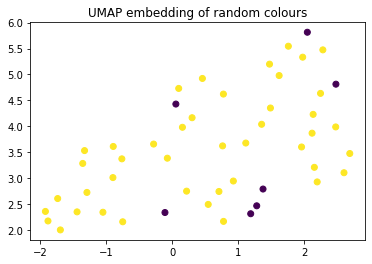

In [90]:
plt.scatter(umap_data[:,0], umap_data[:,1], c=target)
plt.title('UMAP embedding of random colours');

## PCA reduction

In [92]:
''' We will find 4 orthogonal pricniples components here
We may need a lot more in reality - this is where experimentation is helpful! '''

from sklearn.decomposition import PCA

# Fill in the number of components we want
pca = PCA(n_components=4)

# What are we fitting the pca model to/with?
pca.fit(norm_data)

# Use the documentation to figure out how to view the components and the explained variance. 
print(pca.components_)
print(pca.explained_variance_ratio_)

[[-0.00086208  0.00796559  0.00238443 ...  0.00916755  0.00173829
   0.00841552]
 [ 0.00501736 -0.01248215  0.00613107 ...  0.00076035  0.01037719
   0.00602926]
 [-0.00475018 -0.01393547 -0.00396396 ... -0.00681461 -0.00375036
   0.01295061]
 [ 0.00263802 -0.0150638   0.00115801 ...  0.00531752 -0.00080763
   0.01501982]]
[0.31502668 0.1182127  0.05976486 0.05463063]


In [93]:
pca_data = pd.DataFrame(pca.transform(norm_data))
norm_pca = (pca_data-pca_data.min())/(pca_data.max()-pca_data.min()) # pandas will automatically do this by column
display(norm_pca)

,0,1,2,3
0,0.448470,0.014072,0.556149,0.271453
1,0.516281,0.564995,0.181829,0.333944
2,0.480652,0.081416,0.573034,0.282519
3,0.324065,0.148616,0.576653,0.294319
4,0.733636,0.293039,0.475149,0.235415
5,0.480090,0.087204,0.515193,0.285367
6,0.943782,0.797957,0.546991,1.000000
7,0.677472,0.173331,0.333619,0.306250
8,0.238559,0.791469,0.459717,0.218528
9,0.580151,0.147275,0.678939,0.240361


In [94]:
from sklearn.cluster import KMeans

kmeans_pred_scaled = []
kmeans_pred_pca = []
ks = [2, 4, 6] 

for k in ks:
    model = KMeans(n_clusters=k)
    kmeans_pred_pca.append(model.fit_predict(norm_pca))
    kmeans_pred_scaled.append(model.fit_predict(norm_data))

In [95]:
n_correct_pca = np.max([(kmeans_pred_pca[0] == target).sum(), (kmeans_pred_pca[1] != target).sum()])
print("Accuracy after PCA: {}".format(n_correct_pca / len(target)))

n_correct_scaled = np.max([(kmeans_pred_scaled[0] == target).sum(), (kmeans_pred_scaled[1] != target).sum()])
print("Accuracy without PCA: {}".format(n_correct_scaled / len(target)))

Accuracy after PCA: 0.66
Accuracy without PCA: 0.92


In [96]:
''' This loop gives us the top feature of each component using the argmax function '''
top_features = [np.abs(data_reducer.components_[i]).argmax() for i in range(data_reducer.components_.shape[0])]

''' Now, we go back to our original feature names (columns of our dataset), and get the names of the 4 key features '''
top_feature_names = [list(data.columns)[top_features[i]] for i in range(data_reducer.components_.shape[0])]

''' printing the names '''
for n,name in enumerate(top_feature_names):
    print("#" + str(n) + ": " + str(name))

''' finally, extract those 4 features from the original dataset '''
newdata = data[top_feature_names]
print(newdata)

#0: ENSG00000139219
#1: ENSG00000165312
#2: ENSG00000099968
#3: ENSG00000125872
        ENSG00000139219  ENSG00000165312  ENSG00000099968  ENSG00000125872
BRA2                0.0         1.724080        31.080043         0.046597
BRA3                0.0         8.619264        35.407937         0.000000
BRA4                0.0         3.180750        31.725943         0.000000
BRA31               0.0         1.372802        18.434766         0.000000
BRA33               0.0         3.396381        40.701786         0.000000
BRA36               0.0         1.291271        36.517145         0.000000
BRA37               0.0        17.736037        63.429419         0.031842
BRA41               0.0         1.601813        61.042079         0.000000
BRA64               0.0        30.447752        17.870153         0.000000
BRA11               0.0         2.393437        29.967821         0.000000
BRA13               0.0         5.002343        41.739978         0.000000
BRA14               

In [56]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(scaled_data, target, train_size=0.8, random_state=509)

display(x_train)
display(x_test)

array([[0.37878788, 0.56382449, 0.32831494, ..., 0.        , 0.        ,
        0.        ],
       [0.53030303, 0.80614513, 0.0106911 , ..., 0.        , 0.06766429,
        0.        ],
       [0.43939394, 0.38445636, 0.03183197, ..., 0.        , 0.04317117,
        0.        ],
       ...,
       [0.68181818, 0.13579519, 0.04981431, ..., 0.        , 0.        ,
        0.        ],
       [0.22727273, 0.57778388, 0.        , ..., 0.        , 0.08748615,
        0.        ],
       [0.81818182, 0.48669637, 0.14023941, ..., 0.        , 0.        ,
        0.        ]])

array([[0.53030303, 0.6323136 , 0.03532965, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.04564783, ..., 0.        , 0.        ,
        0.12898446],
       [0.81818182, 0.76564548, 0.10230656, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.86363636, 0.7464355 , 0.01573809, ..., 0.        , 0.14229546,
        0.        ],
       [0.72727273, 0.67576487, 0.12137104, ..., 0.        , 0.        ,
        0.        ],
       [0.62121212, 0.17859196, 0.19224427, ..., 0.        , 0.        ,
        0.        ]])

In [57]:
from sklearn.tree import DecisionTreeClassifier

trees = []
for d in [2,5,10,50,100]:
    trees.append(DecisionTreeClassifier(random_state=509, max_depth=d).fit(x_train, y_train))

In [58]:
def get_score(tree, x, y):
    return (tree.get_depth(), tree.score(x, y))
for t in trees:
    print("For max depth of {}".format(t.get_params()["max_depth"]))
    print("\tDepth and Score on train set: {}".format(get_score(t, x_train, y_train)))
    print("\tDepth and score on test set: {}".format(get_score(t, x_test, y_test)))

For max depth of 2
	Depth and Score on train set: (2, 1.0)
	Depth and score on test set: (2, 0.9)
For max depth of 5
	Depth and Score on train set: (2, 1.0)
	Depth and score on test set: (2, 0.9)
For max depth of 10
	Depth and Score on train set: (2, 1.0)
	Depth and score on test set: (2, 0.9)
For max depth of 50
	Depth and Score on train set: (2, 1.0)
	Depth and score on test set: (2, 0.9)
For max depth of 100
	Depth and Score on train set: (2, 1.0)
	Depth and score on test set: (2, 0.9)
